In [ ]:
import pandas as pd
import numpy as np
import time
import os
import sys
from itertools import islice
from collections import defaultdict
import pickle
from __future__ import division
import matplotlib.pyplot as plt
import csv
from sklearn.preprocessing import MinMaxScaler
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
import json
from sklearn.mixture import GaussianMixture
from sklearn.metrics.pairwise import euclidean_distances
import re
from collections import Counter
from tslearn.utils import to_time_series_dataset
from scipy.stats import f_oneway, kruskal
from statsmodels.stats.multitest import multipletests
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram
import ot
from joblib import Parallel, delayed


os.environ["OMP_NUM_THREADS"] = '1'
sys.path.append(os.path.abspath("./src/"))

import backbone_construction
import backbone_time_series
import backbone_update
import utils
import GAM_plots
import cell_state_paths_construction_TimeFlow_2_FlowSOM

from backbone_construction import InitialBackboneConstruction
from cell_state_paths_construction_TimeFlow_2_FlowSOM import CellStatePathConstructorFlowSOM
from backbone_time_series import InitialBackboneTimeSeries
from backbone_update import TimeSeriesDTWMatch 

## TimeFlow 2 (with FlowSOM clusters)
* [Data loading](#data_loading)
* [Lineage detection](#module1)
    * [Steps 1-2](#step_1_step_2)
        * [Pseudotime segmentation and cell states clustering](#pseudotime_and_GMM)
    * [Step 3](#step_3)
        * [Cell state paths](#paths)
    * [Step 4](#step_4)
        * [Intra-segment 2-Wasserstein distances](#wasserstein)
        * [Path costs](#path_costs)
        * [Path grouping](#path_grouping)
    * [Step 5](#step_5)
        * [Leaf clusters](#leaf_clusters)
        * [Leaf absorption (by Pearson correlation)](#pearson)
        * [Leaf absorption (by Dynamic Time Warping)](#DTW)
        * [Pathway refinement](#refinement)    
* [Marker dynamics and lineage extraction](#markers_GAM_models)
* [Saving Metadata](#output)
* [Evaluation](#evaluation)

## Data loading <a class="anchor" id="data_loading"></a>

In this step we load the flow cytometry dataset (CSV file). Features correspond to all cytometry markers and pseudotime (as estimated by [TimeFlow](https://github.com/MargaritaLiarou1/TimeFlow)). 

In [ ]:
df = pd.read_csv("./datasets/P1_BM_pseudotime.csv")

print(df.shape)
print("Dataset columns: ", df.columns)

In [ ]:
# keep only numeric columns and drop 'pseudotime' column 
df = df.drop(["Celltype"], axis=1)
print(df.shape)

## Cell Lineage Detection <a class="anchor" id="module1"></a>

### Steps 1 & 2 <a class="anchor" id="step_1_step_2"></a>

### Pseudotime segmentation and cell states clustering <a id="pseudotime_and_GMM"></a>
We segment the pseudotime axis in ten equal-width segments with 35% width overlap and create clusters (cell states) within each segment using FlowSOM. We set the SOM grid side to 5x5 to create 25 clusters within each segment. 

In [ ]:
# cell states paths with default parameters (for large datasets with more than 150,000 cells)

cell_state_path_costructor = cell_state_paths_construction_TimeFlow_2_FlowSOM.CellStatePathConstructorFlowSOM(df, pseudotime_col='pseudotime',
                                                                               num_segments=10, 
                                                                               overlap_fraction=0.35,
                                                                               SOM_xdim=5, 
                                                                               SOM_ydim=5)

cell_states_results = cell_state_path_costructor.cell_states_creation_full_workflow()
# we only use FlowSOM clusters and not meta-clusters
FlowSOM_clusters = cell_states_results["cluster_results"]
indices_cells = cell_states_results["cluster_indices"]

### Step 3 <a id="step_3"></a>
### Backtracking cell state transitions along pseudotime segments  <a id="paths"></a>
We connect clusters based on maximum amount of cell overlaps to construct paths at cell state level. We refer to the cell state "c" in a segment "S" as *cluster_c_segment_S*. Backtracked paths are saved in dictionary *backtracked_paths*.

In [ ]:
S_final_segments = cell_states_results["S_final_segments"]

connections, backtracked_paths = cell_state_path_costructor.cluster_paths_backtracking(S_final_segments)

print("Print only the first 4 backtracked paths:\n")
for cluster, path in islice(backtracked_paths.items(), 4):
    print(f"Path for {cluster}:\n{path}\n")

### Step 4 <a id="step_4"></a>
### Intra-segment Wasserstein-2 distances <a id="wasserstein"></a>
We compute the pairwise intra-segment $W_2$ distances between the FlowSOM clusters based on the entropic regularization of the Optimal Transport plans (Sinkhorn method, https://pythonot.github.io/all.html#ot.sinkhorn2). 

In [ ]:
segment_cluster_arrays = utils.build_segment_cluster_arrays(cell_states_results)

intra_segment_ot_distances = {}

results = Parallel(n_jobs=-1)(
    delayed(utils.ot_plans_Sinkhorn_FlowSOM)(seg, clusters) for seg, clusters in segment_cluster_arrays.items()
)

intra_segment_wasserstein_distances_dict = dict(results)

In [9]:
intra_segment_w2_dist = pd.DataFrame(
    [(segment, f"{c1},{c2}", w2) for segment, w2_dists in intra_segment_wasserstein_distances_dict.items() for (c1, c2),
     w2 in w2_dists.items()],
    columns=["Segment", "Cluster_pair", "Wasserstein_2_distance"]
)
intra_segment_w2_dist.head(3)

,Segment,Cluster_pair,Wasserstein_2_distance
0,S0,"0,0",0.073868
1,S0,"0,1",0.120804
2,S0,"1,0",0.120804


### Path costs computation <a id="path_costs"></a>
We compute pairwise costs between paths of same length (number of segmnets), by summing the intra-segment $W_2$ distances between their components at corresponding segments.

In [10]:
path_costs = utils.path_costs_computation(backtracked_paths, intra_segment_w2_dist)

print("Print only the first 3 path costs:\n")
for (path1, path2), cost in islice(path_costs.items(), 3):
    print(f"Path cost between {path1} and {path2}: {cost:.4f}")

Print only the first 3 path costs:

Path cost between cluster_9_segment_S1 and cluster_0_segment_S1: 0.4150
Path cost between cluster_9_segment_S1 and cluster_23_segment_S1: 0.3302
Path cost between cluster_9_segment_S1 and cluster_12_segment_S1: 0.3540


### Path grouping <a id="path_grouping"></a>
We extract the pairwise costs for all paths ending in the final segment. We group these paths based on Silhouette score to construct a trajectory backbone (no cell type labels used).

In [54]:
# construct the initial trajectory backbone
# extract path costs only for paths terminating in the final segment
final_segment_key, subset_costs = utils.final_segment_path_costs(path_costs)

print("Final segment key:", final_segment_key)
#print("Subset of path costs:", subset_costs)
# normalize costs 
values = list(subset_costs.values())
v_min, v_max = min(values), max(values)
normalized_costs = {k: (v - v_min) / (v_max - v_min) if v_max != v_min else 0.0 for k, v in subset_costs.items()}

merger = backbone_construction.InitialBackboneConstruction(normalized_costs)
backbone_threshold = merger.silhouette_threshold_selection()
grouped_clusters, ungrouped_clusters = merger.path_group_merging(backbone_threshold)

print("Groups:", grouped_clusters)
# clusters not merged in any group (this is also true for their backtracked paths)
print("Ungrouped clusters:", ungrouped_clusters)

Final segment key: S9
Groups: [{'cluster_21_segment_S9', 'cluster_19_segment_S9', 'cluster_14_segment_S9', 'cluster_17_segment_S9', 'cluster_20_segment_S9', 'cluster_11_segment_S9', 'cluster_6_segment_S9', 'cluster_7_segment_S9', 'cluster_18_segment_S9', 'cluster_10_segment_S9', 'cluster_22_segment_S9', 'cluster_16_segment_S9', 'cluster_2_segment_S9', 'cluster_1_segment_S9', 'cluster_23_segment_S9', 'cluster_9_segment_S9', 'cluster_15_segment_S9', 'cluster_8_segment_S9', 'cluster_5_segment_S9', 'cluster_13_segment_S9', 'cluster_12_segment_S9'}]
Ungrouped clusters: {'cluster_3_segment_S9', 'cluster_0_segment_S9', 'cluster_24_segment_S9', 'cluster_4_segment_S9'}


We print groups of clusters in the final segment and clusters that remain without any group. 

In [41]:
# reformat the initial trajectory backbone into a dictionary where keys are the pathway groups and values
# the cluster_c_segment_s cell states where s here is the final segment 

initial_pathway_groups = merger.initial_backbone_output(grouped_clusters, ungrouped_clusters)

for group, group_states in initial_pathway_groups.items():
    print(f"{group}: {group_states}")

Group_1: ['cluster_21_segment_S9', 'cluster_19_segment_S9', 'cluster_14_segment_S9', 'cluster_17_segment_S9', 'cluster_20_segment_S9', 'cluster_11_segment_S9', 'cluster_6_segment_S9', 'cluster_7_segment_S9', 'cluster_18_segment_S9', 'cluster_10_segment_S9', 'cluster_22_segment_S9', 'cluster_16_segment_S9', 'cluster_2_segment_S9', 'cluster_1_segment_S9', 'cluster_23_segment_S9', 'cluster_9_segment_S9', 'cluster_15_segment_S9', 'cluster_8_segment_S9', 'cluster_5_segment_S9', 'cluster_13_segment_S9', 'cluster_12_segment_S9']
Group_2: ['cluster_0_segment_S9']
Group_3: ['cluster_24_segment_S9']
Group_4: ['cluster_3_segment_S9']
Group_5: ['cluster_4_segment_S9']


### Step 5 <a id="step_5"></a>
### Leaf clusters <a id="leaf_clusters"></a>
We search for all clusters across any segment that have no forward/outgoing connection and do not fall in the final pseudotime segment. We refer to them as "leaf clusters".

In [42]:
leaf_clusters = utils.leaf_clusters_extraction(backtracked_paths)
print(leaf_clusters)

['cluster_23_segment_S1', 'cluster_11_segment_S1', 'cluster_16_segment_S0', 'cluster_6_segment_S1', 'cluster_8_segment_S0', 'cluster_16_segment_S1', 'cluster_1_segment_S0', 'cluster_15_segment_S1', 'cluster_3_segment_S0', 'cluster_3_segment_S1', 'cluster_18_segment_S1', 'cluster_20_segment_S2', 'cluster_4_segment_S2', 'cluster_16_segment_S2', 'cluster_13_segment_S2', 'cluster_17_segment_S2', 'cluster_1_segment_S2', 'cluster_11_segment_S2', 'cluster_5_segment_S2', 'cluster_10_segment_S2', 'cluster_2_segment_S2', 'cluster_0_segment_S2', 'cluster_12_segment_S2', 'cluster_21_segment_S2', 'cluster_7_segment_S2', 'cluster_18_segment_S2', 'cluster_5_segment_S3', 'cluster_6_segment_S3', 'cluster_12_segment_S3', 'cluster_13_segment_S3', 'cluster_18_segment_S3', 'cluster_4_segment_S3', 'cluster_17_segment_S3', 'cluster_21_segment_S3', 'cluster_8_segment_S3', 'cluster_3_segment_S3', 'cluster_19_segment_S3', 'cluster_9_segment_S3', 'cluster_11_segment_S3', 'cluster_23_segment_S3', 'cluster_5_segme

For each leaf cluster we find its top-4 closest clusters based on intra-segment $W_2$ distances.

In [43]:
top_N_results = utils.top_N_cluster_search(leaf_clusters, intra_segment_wasserstein_distances_dict, top_N=4)

# print the top-N closest cluster of each leaf cluster 
for top in top_N_results:
    print(f"\n{top.upper()} closest clusters")
    for segment, pairs in top_N_results[top].items():
        for cluster, matches in pairs.items():
            print(f"{cluster} in {segment}: {matches}")


TOP_1 closest clusters
cluster_3 in S1: ['cluster_7']
cluster_6 in S1: ['cluster_16']
cluster_11 in S1: ['cluster_13']
cluster_15 in S1: ['cluster_20']
cluster_16 in S1: ['cluster_6']
cluster_18 in S1: ['cluster_13']
cluster_23 in S1: ['cluster_17']
cluster_16 in S0: ['cluster_7']
cluster_8 in S0: ['cluster_12']
cluster_3 in S0: ['cluster_2']
cluster_1 in S0: ['cluster_0']
cluster_0 in S2: ['cluster_5']
cluster_1 in S2: ['cluster_6']
cluster_2 in S2: ['cluster_7']
cluster_4 in S2: ['cluster_3']
cluster_5 in S2: ['cluster_10']
cluster_7 in S2: ['cluster_2']
cluster_10 in S2: ['cluster_5']
cluster_11 in S2: ['cluster_16']
cluster_12 in S2: ['cluster_13']
cluster_13 in S2: ['cluster_21']
cluster_16 in S2: ['cluster_11']
cluster_17 in S2: ['cluster_11']
cluster_18 in S2: ['cluster_13']
cluster_20 in S2: ['cluster_5']
cluster_21 in S2: ['cluster_13']
cluster_3 in S3: ['cluster_8']
cluster_4 in S3: ['cluster_3']
cluster_5 in S3: ['cluster_0']
cluster_6 in S3: ['cluster_2']
cluster_8 in S3: 

### Leaf absorption based on Pearson correlation <a id="pearson"></a>
We absorb leaf clusters' paths by the backbone trajectory based on the rule described in manuscript section 2.3.5. 

First, we convert each backtracked path into a time series. Each time series has as many time steps as the number of segments the path traverses. Every time step is characterized by a $D$-dimensional vector (here $D=20$), which corresponds to the number of markers. To compute the vector values, we compute the mean of each feature over all cells belonging to states/clusters along the path. Then, we compute the Pearson correlation between the path of each leaf cluster and the path of its top-1 closest cluster. Finally, we distinguish between high and low correlated pairs of clusters based on the Pearson correlation threshold.

In [44]:
# retrieve only the unique cluster_c_segment_S clusters that appear along the segments of each pathway group
group_unique_cluster_segments = merger.unique_cluster_segments_extraction_from_paths(initial_pathway_groups, backtracked_paths)

#for group, segments in group_unique_cluster_segments.items():
#    print(f"\n{group}:")
#    for segment in segments:
#        print(f"{segment}")

indices_cells = cell_states_results["cluster_indices"]
# make a time series for each pathway group using the mean values of the markers in each cluster
time_series_per_group = utils.build_group_time_series_numeric_only(group_unique_cluster_segments,indices_cells,df)

print(len(time_series_per_group))
#print(time_series_per_group["Group_1"][0])

5


In [45]:
# make time series for each backtracked path and assign them in a dictionary where keys are paths
time_series_per_path = utils.build_path_time_series_numeric_only(backtracked_paths,indices_cells, df)
len(time_series_per_path)
#time_series_per_path

225

In [46]:
# ts learn objects for time series
# (n_series, max_timesteps, n_features) with padding if needed
time_series_per_group_list= [np.vstack(group) for group in time_series_per_group.values()]
time_series_per_group_dataset = to_time_series_dataset(time_series_per_group_list)
time_series_per_group_dataset.shape

(5, 10, 20)

In [47]:
similarities, merge_pairs, threshold, low_corr_only_sources = utils.compute_cluster_correlation_similarity_percentile_FlowSOM(
    top_N_results["top_1"], indices_cells, high_corr_guard=0.9, pearson_corr_threshold=0.85, percentile_10_threshold=0.75, time_series_per_path = time_series_per_path
)
low_corr_only_sources = [item for sublist in low_corr_only_sources.values() for item in sublist]

🔹 Global 10th percentile = 0.877 → threshold = 0.75
cluster_3_segment_S1 ↔ cluster_7_segment_S1: corr=0.956 → Above threshold
cluster_6_segment_S1 ↔ cluster_16_segment_S1: corr=0.964 → Above threshold
cluster_11_segment_S1 ↔ cluster_13_segment_S1: corr=0.961 → Above threshold
cluster_15_segment_S1 ↔ cluster_20_segment_S1: corr=0.972 → Above threshold
cluster_16_segment_S1 ↔ cluster_6_segment_S1: corr=0.964 → Above threshold
cluster_18_segment_S1 ↔ cluster_13_segment_S1: corr=0.960 → Above threshold
cluster_23_segment_S1 ↔ cluster_17_segment_S1: corr=0.985 → Above threshold
cluster_0_segment_S2 ↔ cluster_5_segment_S2: corr=0.965 → Above threshold
cluster_1_segment_S2 ↔ cluster_6_segment_S2: corr=0.962 → Above threshold
cluster_2_segment_S2 ↔ cluster_7_segment_S2: corr=0.962 → Above threshold
cluster_4_segment_S2 ↔ cluster_3_segment_S2: corr=0.980 → Above threshold
cluster_5_segment_S2 ↔ cluster_10_segment_S2: corr=0.976 → Above threshold
cluster_7_segment_S2 ↔ cluster_2_segment_S2: corr

In [48]:
from collections import defaultdict

flat_per_segment, formatted_source_list = utils.matching_sources_FlowSOM(
    top_N_results=top_N_results,
    group_unique_cluster_segments=group_unique_cluster_segments
)

print(flat_per_segment)
print(formatted_source_list)

grouped_dict_low_corr, clusters_for_dtw_absorption = utils.leaf_clusters_groups(
    formatted_source_list,
    low_corr_only_sources,
    leaf_clusters
)

print(grouped_dict_low_corr)
print(f"Number of states for DTW absorption: {len(clusters_for_dtw_absorption)}")

grouped_dict_low_corr_unique_cluster_segments = utils.extract_unique_segments_per_group(
    grouped_dict_low_corr,
    backtracked_paths,
    utils.reformat_value
)

for group, segments in grouped_dict_low_corr_unique_cluster_segments.items():
    print(f"\n{group}:")
    for segment in segments:
        print(f"  {segment}")

grouped_dict_low_corr_unique_cluster_segments


{}
[]
{'Group_1': ['cluster_16_segment_S0'], 'Group_2': ['cluster_8_segment_S0'], 'Group_3': ['cluster_3_segment_S0'], 'Group_4': ['cluster_1_segment_S0'], 'Group_5': ['cluster_3_segment_S8']}
Number of states for DTW absorption: 82

Group_1:

Group_2:

Group_3:

Group_4:

Group_5:
  cluster_0_segment_S1
  cluster_10_segment_S3
  cluster_10_segment_S5
  cluster_11_segment_S7
  cluster_12_segment_S4
  cluster_19_segment_S2
  cluster_24_segment_S0
  cluster_3_segment_S8
  cluster_7_segment_S6


{'Group_1': [],
 'Group_2': [],
 'Group_3': [],
 'Group_4': [],
 'Group_5': ['cluster_0_segment_S1',
  'cluster_10_segment_S3',
  'cluster_10_segment_S5',
  'cluster_11_segment_S7',
  'cluster_12_segment_S4',
  'cluster_19_segment_S2',
  'cluster_24_segment_S0',
  'cluster_3_segment_S8',
  'cluster_7_segment_S6']}

We also collect the unique leaf clusters (sources) whose top-N closest clusters (targets) are themselves leaf clusters, and thus cannot be considered as "explored clusters".  We combine these clusters with leaf clusters that have low correlation with their top-1 closest cluster, and proceed with the trajectory update. Any leaf cluster not falling in the above categories will be absorbed by any of the updated backbone pathways based on smallest DTW distances.

In [49]:
grouped_dict_low_corr, clusters_for_dtw_absorption = utils.leaf_clusters_groups(
    formatted_source_list,
    low_corr_only_sources,
    leaf_clusters
)

print(grouped_dict_low_corr)
print(f"Number of states for DTW absorption: {len(clusters_for_dtw_absorption)}")

grouped_dict_low_corr_unique_cluster_segments = utils.extract_unique_segments_per_group(
    grouped_dict_low_corr,
    backtracked_paths,
    utils.reformat_value
)

for group, segments in grouped_dict_low_corr_unique_cluster_segments.items():
    print(f"\n{group}:")
    for segment in segments:
        print(f"  {segment}")

grouped_dict_low_corr_unique_cluster_segments

{'Group_1': ['cluster_16_segment_S0'], 'Group_2': ['cluster_8_segment_S0'], 'Group_3': ['cluster_3_segment_S0'], 'Group_4': ['cluster_1_segment_S0'], 'Group_5': ['cluster_3_segment_S8']}
Number of states for DTW absorption: 82

Group_1:

Group_2:

Group_3:

Group_4:

Group_5:
  cluster_0_segment_S1
  cluster_10_segment_S3
  cluster_10_segment_S5
  cluster_11_segment_S7
  cluster_12_segment_S4
  cluster_19_segment_S2
  cluster_24_segment_S0
  cluster_3_segment_S8
  cluster_7_segment_S6


{'Group_1': [],
 'Group_2': [],
 'Group_3': [],
 'Group_4': [],
 'Group_5': ['cluster_0_segment_S1',
  'cluster_10_segment_S3',
  'cluster_10_segment_S5',
  'cluster_11_segment_S7',
  'cluster_12_segment_S4',
  'cluster_19_segment_S2',
  'cluster_24_segment_S0',
  'cluster_3_segment_S8',
  'cluster_7_segment_S6']}

In [50]:
if any(not value for value in grouped_dict_low_corr_unique_cluster_segments.values()):
    grouped_dict_low_corr_unique_cluster_segments = {key: value for key, value in grouped_dict_low_corr_unique_cluster_segments.items() if value}
grouped_dict_low_corr_unique_cluster_segments

{'Group_5': ['cluster_0_segment_S1',
  'cluster_10_segment_S3',
  'cluster_10_segment_S5',
  'cluster_11_segment_S7',
  'cluster_12_segment_S4',
  'cluster_19_segment_S2',
  'cluster_24_segment_S0',
  'cluster_3_segment_S8',
  'cluster_7_segment_S6']}

We update the trajectory backbone by adding as new candidate pathway groups the paths of all leaf clusters that had low correlation. If no such a case, the backbone remains the same. 

In [51]:
def merge_and_renumber_groups(*group_dicts):
    # collect all cluster groups from all input dictionaries
    all_groups = []
    for group_dict in group_dicts:
        all_groups.extend(group_dict.values())

    merged = {f"Group_{i+1}": group for i, group in enumerate(all_groups)}
    return merged

updated_backbone = merge_and_renumber_groups(group_unique_cluster_segments, grouped_dict_low_corr_unique_cluster_segments)
#merged_groups = merge_and_renumber_groups(updated_group_clusters, unmatched_group_unique_cluster_segments)

for group, clusters in updated_backbone.items():
    print(f"{group}: {clusters}")


Group_1: ['cluster_0_segment_S5', 'cluster_0_segment_S8', 'cluster_10_segment_S8', 'cluster_10_segment_S9', 'cluster_11_segment_S8', 'cluster_11_segment_S9', 'cluster_12_segment_S1', 'cluster_12_segment_S9', 'cluster_13_segment_S9', 'cluster_14_segment_S3', 'cluster_14_segment_S7', 'cluster_14_segment_S9', 'cluster_15_segment_S8', 'cluster_15_segment_S9', 'cluster_16_segment_S6', 'cluster_16_segment_S9', 'cluster_17_segment_S6', 'cluster_17_segment_S8', 'cluster_17_segment_S9', 'cluster_18_segment_S9', 'cluster_19_segment_S9', 'cluster_1_segment_S9', 'cluster_20_segment_S8', 'cluster_20_segment_S9', 'cluster_21_segment_S8', 'cluster_21_segment_S9', 'cluster_22_segment_S8', 'cluster_22_segment_S9', 'cluster_23_segment_S4', 'cluster_23_segment_S9', 'cluster_2_segment_S7', 'cluster_2_segment_S8', 'cluster_2_segment_S9', 'cluster_4_segment_S0', 'cluster_4_segment_S7', 'cluster_5_segment_S9', 'cluster_6_segment_S2', 'cluster_6_segment_S9', 'cluster_7_segment_S9', 'cluster_8_segment_S7', 'cl

### Leaf absorption based on Dynamic Time Warping <a id="DTW"></a>

We convert the updated backbone into time series in the same way we described earlier. We compare these time series to the ones of the unabsorbed leaf clusters' paths based on DTW which is suitable for uni-/multi-variate time series of unequal length. We update the pathway groups and remove duplicate cell states from them. 

In [52]:
import time_series_utils
from time_series_utils import PathTimeSeriesConstructor
# prepare time series datasets to use for DTW
builder = time_series_utils.PathTimeSeriesConstructor(df)
updated_backbone_ts = builder.path_group_time_series(updated_backbone, indices_cells)
updated_backbone_dataset_ts = builder.ts_learn_convertion(updated_backbone_ts)

print(updated_backbone_dataset_ts.shape)

(6, 10, 20)


In [53]:
filtered_unmatched_states = clusters_for_dtw_absorption

grouped_dict_unmatched = {f"Group_{i+1}": [item] for i, item in enumerate(filtered_unmatched_states)}
#grouped_dict_unmatched
unmatched_group_unique_cluster_segments = builder.group_unique_segment_extraction(grouped_dict_unmatched, backtracked_paths)

for group, segments in unmatched_group_unique_cluster_segments.items():
    print(f"\n{group}:")
    for segment in segments:
        print(f"  {segment}")

unmatched_group_unique_cluster_segments = builder.empty_groups_removal(unmatched_group_unique_cluster_segments)
ts_unmatched = builder.path_group_time_series(unmatched_group_unique_cluster_segments,indices_cells)
unmatched_ts_dataset = builder.ts_learn_convertion(ts_unmatched)
print(unmatched_ts_dataset.shape)

matcher = backbone_update.TimeSeriesDTWMatch(
    unmatched_ts=unmatched_ts_dataset,
    main_ts=updated_backbone_dataset_ts,
    unmatched_clusters=unmatched_group_unique_cluster_segments,
    main_clusters=updated_backbone
)

updated_main_no_duplicates = matcher.backbone_update_full_workflow()

merged_groups=updated_main_no_duplicates


Group_1:
  cluster_15_segment_S0
  cluster_23_segment_S1

Group_2:
  cluster_11_segment_S1
  cluster_19_segment_S0

Group_3:
  cluster_16_segment_S0
  cluster_6_segment_S1

Group_4:
  cluster_16_segment_S1
  cluster_8_segment_S0

Group_5:
  cluster_15_segment_S1
  cluster_1_segment_S0

Group_6:
  cluster_3_segment_S0
  cluster_3_segment_S1

Group_7:
  cluster_18_segment_S1
  cluster_20_segment_S0

Group_8:
  cluster_20_segment_S2
  cluster_24_segment_S1
  cluster_5_segment_S0

Group_9:
  cluster_11_segment_S0
  cluster_14_segment_S1
  cluster_4_segment_S2

Group_10:
  cluster_13_segment_S1
  cluster_16_segment_S2
  cluster_9_segment_S0

Group_11:
  cluster_13_segment_S2
  cluster_19_segment_S0
  cluster_5_segment_S1

Group_12:
  cluster_10_segment_S0
  cluster_17_segment_S2
  cluster_9_segment_S1

Group_13:
  cluster_0_segment_S0
  cluster_1_segment_S2
  cluster_21_segment_S1

Group_14:
  cluster_11_segment_S2
  cluster_14_segment_S0
  cluster_7_segment_S1

Group_15:
  cluster_15_segm

Absorbing time series with DTW:  59%|████████████████████████████▋                    | 48/82 [00:00<00:00, 475.84it/s]

Unmatched[0] leaf cluster matches best with backbone Main[5] at DTW distance 6.08
Unmatched[1] leaf cluster matches best with backbone Main[5] at DTW distance 5.17
Unmatched[2] leaf cluster matches best with backbone Main[5] at DTW distance 5.57
Unmatched[3] leaf cluster matches best with backbone Main[5] at DTW distance 5.97
Unmatched[4] leaf cluster matches best with backbone Main[5] at DTW distance 6.59
Unmatched[5] leaf cluster matches best with backbone Main[5] at DTW distance 5.94
Unmatched[6] leaf cluster matches best with backbone Main[5] at DTW distance 5.44
Unmatched[7] leaf cluster matches best with backbone Main[5] at DTW distance 6.02
Unmatched[8] leaf cluster matches best with backbone Main[5] at DTW distance 5.10
Unmatched[9] leaf cluster matches best with backbone Main[5] at DTW distance 5.62
Unmatched[10] leaf cluster matches best with backbone Main[5] at DTW distance 5.06
Unmatched[11] leaf cluster matches best with backbone Main[5] at DTW distance 5.41
Unmatched[12] 

Absorbing time series with DTW: 100%|█████████████████████████████████████████████████| 82/82 [00:00<00:00, 356.63it/s]


### Pathway refinement <a id="refinement"></a>

Before refining the trajectory backbone with a final step, we retrieve the cells of each detected pathway group and create different datasets.

In [55]:
import re
import pandas as pd

df = pd.read_csv("./datasets/P1_BM_pseudotime.csv")

filtered_group_dfs = {}

def reformat_value(value):
    segments = re.findall(r'segment (\d+), cluster (\d+)', value)
    return [f'cluster_{cluster}_segment_S{segment}' for segment, cluster in segments]

for group_name, keys_to_fetch in updated_main_no_duplicates.items():
    unique_cluster_segments = set()
    unique_indices = set()

    for key in keys_to_fetch:
        path_value = backtracked_paths.get(key)
        if path_value:
            segments = reformat_value(path_value)
            unique_cluster_segments.update(segments)
        else:
            match = re.match(r'cluster_(\d+)_S0', key)
            if match:
                cluster_number = int(match.group(1))
                if cluster_number in indices_cells.get("S0", {}):
                    unique_indices.update(indices_cells["S0"][cluster_number])

    for cluster_segment in unique_cluster_segments:
        cluster_part = cluster_segment.split('_')[1]
        segment_part = cluster_segment.split('_')[-1]
        segment_number = segment_part.replace('S', '')
        segment_key = f"S{segment_number}"
        cluster_number = int(cluster_part)

        if segment_key in indices_cells and cluster_number in indices_cells[segment_key]:
            unique_indices.update(indices_cells[segment_key][cluster_number])

    unique_indices_list = sorted(unique_indices)
    filtered_df = df.loc[unique_indices_list]

    filtered_df = filtered_df.drop_duplicates()

    filtered_group_dfs[group_name] = filtered_df

    print(f"\n=== {group_name} ===")
    print(filtered_df.Celltype.value_counts())
    print(filtered_df.shape)



=== Group_1 ===
n3    180244
n4     93028
n2     86376
m2      1622
n1       344
e1       327
m1       320
m3       239
e4        49
e3        12
e2         9
b1         3
b3         1
Name: Celltype, dtype: int64
(362574, 22)

=== Group_2 ===
n4    6824
m2     663
m3     616
m1     363
n1     234
e3     133
e1     131
e4      60
n2      57
e2      35
n3      30
b3       4
Name: Celltype, dtype: int64
(9150, 22)

=== Group_3 ===
m3    18054
m2     6421
n2      962
m1      426
n1      248
e1      131
n3       15
e2        1
Name: Celltype, dtype: int64
(26258, 22)

=== Group_4 ===
b3    15856
b2     1444
n1      382
b1      322
e1      284
m1      194
e4       73
m2       26
e2       18
n2       16
e3        6
n3        1
m3        1
Name: Celltype, dtype: int64
(18623, 22)

=== Group_5 ===
e4    28538
e3    23580
e1      676
n1      672
m1      656
m2      581
e2      104
m3       75
n2       60
b1        6
n3        3
b3        2
Name: Celltype, dtype: int64
(54953, 22)

=== Group_6 

In [56]:
# retrieve top 5% cells with highest pseudotime value for each pathway group
terminal_cells = utils.get_top_5pct_cells_labeled(filtered_group_dfs)

summary_df, scores, best_thresold = utils.summarize_and_cluster_groups(df=df, group_df=terminal_cells, 
                                                                group_col='original_group', 
                                                                exclude_col='pseudotime',
                                                                manual_threshold=None)

refined_pathway_groups  = utils.merge_groups_by_cluster(summary_df, filtered_group_dfs)

Cluster assignment for each group:
                cluster
original_group         
Group_1               1
Group_2               1
Group_3               4
Group_4               3
Group_5               2
Group_6               2


### Marker dynamics and lineage extraction <a id="markers_GAM_models"></a>

We select four CD markers with lineage-specific or well-known patterns, such as CD14 (monocytes), CD16 (neutrophils), CD36 (erythrocytes) and CD19 (B-cells). We fit their evolution across each inferred pathway as a function of pseudotime using a Generalized Additive Model with ten cubic splines. Finally, we save each pathway as a separate CSV file in the P1 results folder. The set of markers may be adjusted to guide subsequent annotation of the pathways based on the available panel of markers.

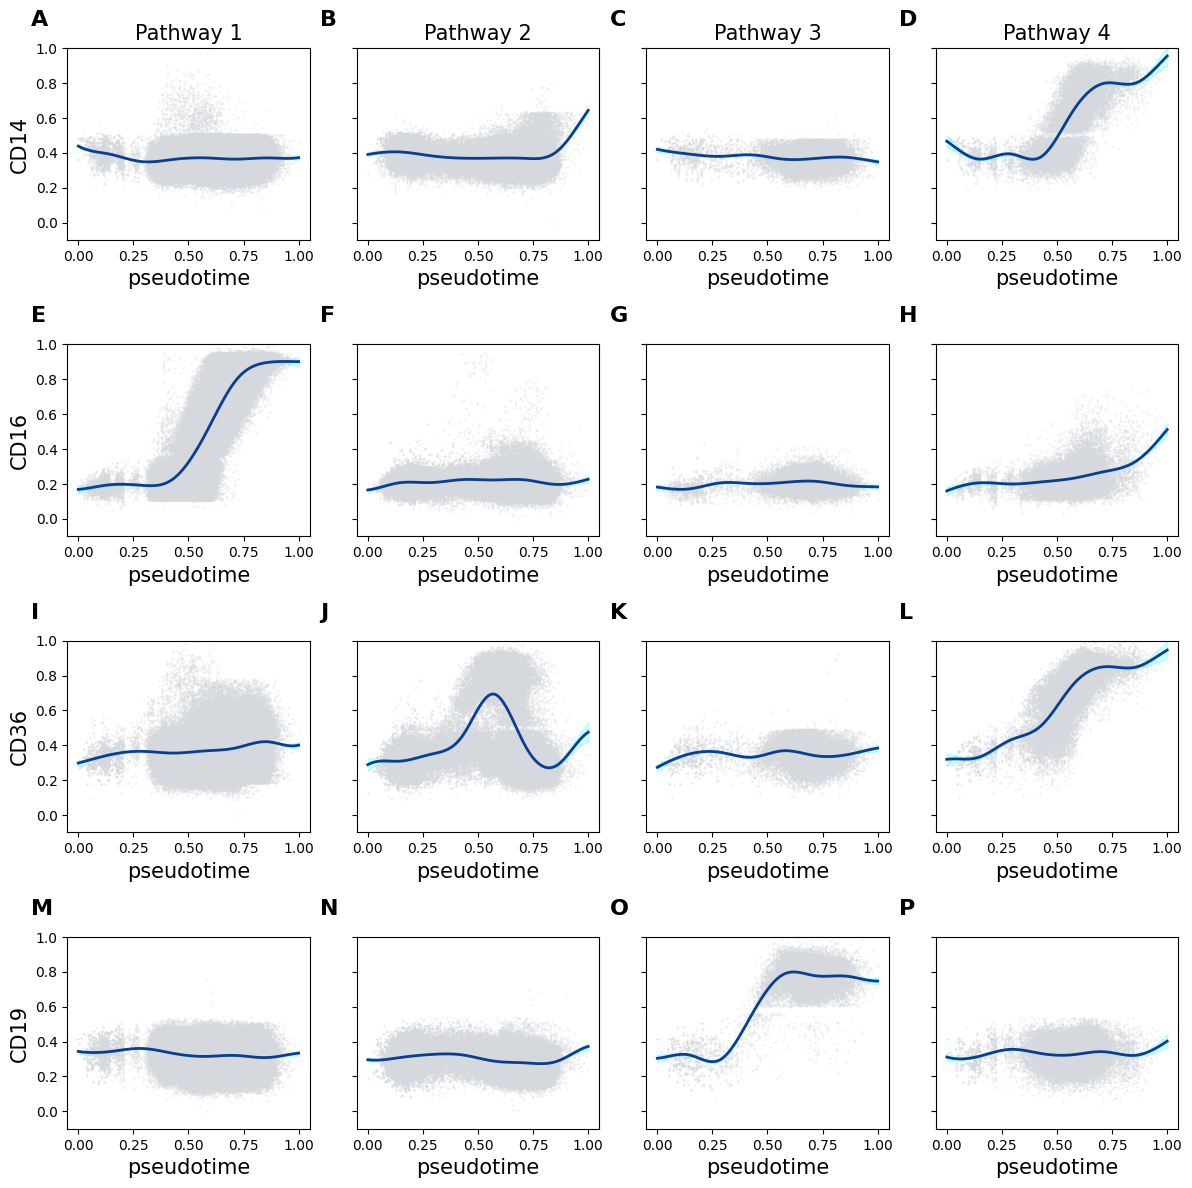

In [57]:
GAM_plots.marker_evolution_visualization_and_lineage_extraction(refined_pathway_groups,
                                                              markers=['CD14', 'CD16', 'CD36', 'CD19'],
                                                              output_folder='./results/P1/FlowSOM-variant/lineage-csv-files-FlowSOM-variant/')

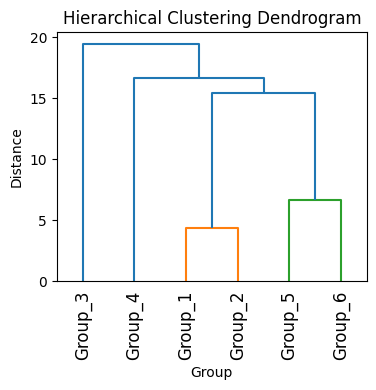

Threshold 0.10: Number of clusters = 6
Threshold 0.30: Number of clusters = 6
Threshold 0.50: Number of clusters = 6
Threshold 0.71: Number of clusters = 6
Threshold 0.91: Number of clusters = 6
Threshold 1.11: Number of clusters = 6
Threshold 1.31: Number of clusters = 6
Threshold 1.51: Number of clusters = 6
Threshold 1.72: Number of clusters = 6
Threshold 1.92: Number of clusters = 6
Threshold 2.12: Number of clusters = 6
Threshold 2.32: Number of clusters = 6
Threshold 2.52: Number of clusters = 6
Threshold 2.73: Number of clusters = 6
Threshold 2.93: Number of clusters = 6
Threshold 3.13: Number of clusters = 6
Threshold 3.33: Number of clusters = 6
Threshold 3.53: Number of clusters = 6
Threshold 3.74: Number of clusters = 6
Threshold 3.94: Number of clusters = 6
Threshold 4.14: Number of clusters = 6
Threshold 4.34: Number of clusters = 6
Threshold 4.54: Number of clusters = 5
Threshold 4.75: Number of clusters = 5
Threshold 4.95: Number of clusters = 5
Threshold 5.15: Number of

In [58]:
def get_top_10pct_cells_labeled(data_dict, pseudotime_col='pseudotime'):
    dfs = []
    for group, df in data_dict.items():
        cutoff = df[pseudotime_col].quantile(0.95)
        top_df = df[df[pseudotime_col] >= cutoff].copy()
        top_df['OriginalGroup'] = group
        dfs.append(top_df)
    return pd.concat(dfs, ignore_index=True)
from sklearn.preprocessing import StandardScaler

top_cells = get_top_10pct_cells_labeled(filtered_group_dfs)

X = top_cells.select_dtypes(include=[np.number])
X_scaled = StandardScaler().fit_transform(X)
features = top_cells.select_dtypes(include=[np.number]).drop(columns=['pseudotime'], errors='ignore')
groups = top_cells['OriginalGroup'].unique()
results = []

for feature in features.columns:
    data_by_group = [top_cells[top_cells['OriginalGroup'] == g][feature].values for g in groups]
    
    try:
        stat, pval = f_oneway(*data_by_group) 
    except:
        stat, pval = kruskal(*data_by_group)  

    results.append({'Feature': feature, 'F-stat': stat, 'p-value': pval})
    
result_df = pd.DataFrame(results)
result_df['adj_pval'] = result_df['p-value'] * len(result_df)  
result_df = result_df.sort_values('p-value')

# rank markers based on p-val, all markers will be eventually used
_, adj_pvals, _, _ = multipletests(result_df['p-value'], method='fdr_bh')
result_df['adj_pval_fdr'] = adj_pvals
significant_markers = result_df[result_df['adj_pval_fdr'] < 0.05]


top_features = significant_markers['Feature'].head(10)
top_features = significant_markers['Feature'].head(10)
top_markers = significant_markers.sort_values('adj_pval_fdr').head(50)['Feature'].tolist()

summary_stats = []

# summary statistics for terminal cells of each pathway
for group, group_df in top_cells.groupby('OriginalGroup'):
    stats = {'OriginalGroup': group}
    for feature in top_markers:
        values = group_df[feature].dropna()
        stats[f'{feature}_mean'] = values.mean()
        stats[f'{feature}_median'] = values.median()
        stats[f'{feature}_q25'] = values.quantile(0.25)
        stats[f'{feature}_q75'] = values.quantile(0.75)
    summary_stats.append(stats)

summary_df = pd.DataFrame(summary_stats).set_index('OriginalGroup')
scaler = StandardScaler()
X_summary = scaler.fit_transform(summary_df)

# linkage matrix for hierarchical clustering
Z = linkage(X_summary, method='ward')

# dendrogram and merges for different thresholds
plt.figure(figsize=(4,4))
dendrogram(Z, labels=summary_df.index, leaf_rotation=90)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Group')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

thresholds = np.linspace(0.1, 10, 50)
# thresholds and compute silhouette scores
silhouette_scores = []

for t in thresholds:
    clusters = fcluster(Z, t=t, criterion='distance')
    n_clusters = len(set(clusters))
    n_samples = len(clusters)
    print(f"Threshold {t:.2f}: Number of clusters = {n_clusters}")
    
    if n_clusters > 1 and n_clusters < n_samples:
        score = silhouette_score(X_summary, clusters)
    else:
        score = np.nan
    silhouette_scores.append(score)

if all(np.isnan(silhouette_scores)):
    print("No valid clustering found in threshold range. Assigning singleton clusters (each group its own cluster).")
    # cluster IDs = 1..n_samples 
    summary_df['Cluster'] = range(1, len(summary_df) + 1)
else:
    best_idx = np.nanargmax(silhouette_scores)
    best_threshold = thresholds[best_idx]
    best_score = silhouette_scores[best_idx]
    final_clusters = fcluster(Z, t=best_threshold, criterion='distance')
    summary_df['Cluster'] = final_clusters
    print(f"Best distance threshold: {best_threshold:.3f}")
    print(f"Best silhouette score: {best_score:.3f}")

print("Cluster assignment for each group:")
print(summary_df[['Cluster']])


In [59]:
import pandas as pd

def merge_groups_by_cluster(summary_df, filtered_group_dfs):

    if summary_df.index.name == 'OriginalGroup':
        summary_df = summary_df.reset_index()

    cluster_to_groups = summary_df.groupby('Cluster')['OriginalGroup'].apply(list).to_dict()

    merged_dict = {}
    celltype_stats = {}

    for cluster, groups in cluster_to_groups.items():
        merged_df = pd.concat([filtered_group_dfs[group] for group in groups], axis=0)
        merged_df = merged_df.drop_duplicates()

        merged_dict[cluster] = merged_df

        counts = merged_df['Celltype'].value_counts()
        proportions = merged_df['Celltype'].value_counts(normalize=True)

        celltype_stats[cluster] = pd.DataFrame({
            'Count': counts,
            'Proportion': proportions
        })

    return merged_dict, celltype_stats

merged_dict, celltype_stats = merge_groups_by_cluster(summary_df, filtered_group_dfs)

for cluster, stats_df in celltype_stats.items():
    print(f"Cluster {cluster} Celltype counts and proportions:")
    print(stats_df)
    print()


Cluster 1 Celltype counts and proportions:
     Count  Proportion
n3  180272    0.485129
n4   99836    0.268668
n2   86411    0.232540
m2    2254    0.006066
m3     816    0.002196
m1     683    0.001838
n1     578    0.001555
e1     458    0.001233
e3     138    0.000371
e4     100    0.000269
e2      43    0.000116
b3       4    0.000011
b1       3    0.000008

Cluster 2 Celltype counts and proportions:
    Count  Proportion
e4  30257    0.331072
e3  24085    0.263538
n2   8774    0.096005
m1   7659    0.083805
n1   6609    0.072316
e1   5979    0.065422
m2   5073    0.055509
e2   1777    0.019444
b1    581    0.006357
n3    423    0.004628
m3    134    0.001466
n4     35    0.000383
b3      5    0.000055

Cluster 3 Celltype counts and proportions:
    Count  Proportion
b3  15856    0.851420
b2   1444    0.077539
n1    382    0.020512
b1    322    0.017290
e1    284    0.015250
m1    194    0.010417
e4     73    0.003920
m2     26    0.001396
e2     18    0.000967
n2     16    0.0008

### Saving metadata <a id="output"></a>
We save/load other relevant results/metadata in dictionaries.

In [61]:
# save each pathway/lineage separately in a CSV file to use for visualization and marker dynamics modeling
# here we retain cell indices per lineage only for evaluation
# if a Celltype column does not exist set index below to False
# pseudotime below is not scaled in [0,1]

for i, pathway_dict in enumerate(refined_pathway_groups):
    for key, df in pathway_dict.items():
        filename = f"./results/P1/FlowSOM-variant/lineage_dataset_with_celltypes_indices_{key}.csv"
        df.to_csv(filename, index=True)
        
# saving
with open('./results/P1/FlowSOM-variant/P1_cluster_cell_state_results.pkl', 'wb') as f:
    pickle.dump(cell_states_results, f)
    
with open('./results/P1/FlowSOM-variant/P1_backtracked_paths.pkl', 'wb') as f:
    pickle.dump(backtracked_paths, f)

with open('./results/P1/FlowSOM-variant/P1_cell_state_connections_and_overlaps.pkl', 'wb') as f:
    pickle.dump(connections, f)

with open('./results/P1/FlowSOM-variant/P1_intra_segment_wasserstein_distances_dict.pkl', 'wb') as f:
    pickle.dump(intra_segment_wasserstein_distances_dict, f)
    
with open('./results/P1/FlowSOM-variant/P1_path_costs.pkl', 'wb') as f:
    pickle.dump(path_costs, f)

with open('./results/P1/FlowSOM-variant/P1_pathways_without_celltypes.pkl', 'wb') as f:
    pickle.dump(refined_pathway_groups, f)
    
# example to load a dictionary
#with open('./results/P1/P1_path_costs.pkl', 'rb') as f:
#    path_costs = pickle.load(f)

In [63]:
with open('./results/P1/FlowSOM-variant/P1_cluster_cell_state_results.pkl', 'wb') as f:
    pickle.dump(cell_states_results, f)
    
with open('./results/P1/FlowSOM-variant/P1_backtracked_paths.pkl', 'wb') as f:
    pickle.dump(backtracked_paths, f)

with open('./results/P1/FlowSOM-variant/P1_cell_state_connections.pkl', 'wb') as f:
    pickle.dump(connections, f)

with open('./results/P1/FlowSOM-variant/P1_intra_segment_wasserstein_distances_dict.pkl', 'wb') as f:
    pickle.dump(intra_segment_wasserstein_distances_dict, f)
    
with open('./results/P1/FlowSOM-variant/P1_path_costs.pkl', 'wb') as f:
    pickle.dump(path_costs, f)


In [ ]:
# load results test
with open('./results/P1/FlowSOM-variant/P1_path_costs.pkl', 'rb') as f:
    path_costs = pickle.load(f)

# load results test
with open('./results/P1/FlowSOM-variant/P1_intra_segment_wasserstein_distances_dict.pkl', 'rb') as f:
    intra_segment_wasserstein_distances_dict = pickle.load(f)

with open('./results/P1/FlowSOM-variant/P1_cell_state_connections.pkl', 'rb') as f:
    connections = pickle.load(f)
    
with open('./results/P1/FlowSOM-variant/P1_backtracked_paths.pkl', 'rb') as f:
    backtracked_paths = pickle.load(f)
    
with open('./results/P1/FlowSOM-variant/P1_cluster_cell_state_results.pkl', 'rb') as f:
    cell_state_results = pickle.load(f)
    

### Evaluation <a id="evaluation"></a>
We compute the cell type proportions in each automatically inferred lineage/pathway using the ground truth cell type labels if available.

#### change to FlowSOM results folder
original_df = pd.read_csv("./datasets/P1_BM_pseudotime.csv")

lineage_1 = pd.read_csv("./results/P1/lineages-csv-files/lineage_dataset_with_celltypes_indices_1.csv")
lineage_2 = pd.read_csv("./results/P1/lineages-csv-files/lineage_dataset_with_celltypes_indices_2.csv")
lineage_3 = pd.read_csv("./results/P1/lineages-csv-files/lineage_dataset_with_celltypes_indices_3.csv")
lineage_4 = pd.read_csv("./results/P1/lineages-csv-files/lineage_dataset_with_celltypes_indices_4.csv")

#### extract cell indices in each lineage dataset and subset original dataset for these indices
lin_1_indices = lineage_1.iloc[:, 0].tolist()
lin_2_indices = lineage_2.iloc[:, 0].tolist()
lin_3_indices = lineage_3.iloc[:, 0].tolist()
lin_4_indices = lineage_4.iloc[:, 0].tolist()

evaluation_lin_1 = original_df.loc[lin_1_indices]
evaluation_lin_2 = original_df.loc[lin_2_indices]
evaluation_lin_3 = original_df.loc[lin_3_indices]
evaluation_lin_4 = original_df.loc[lin_4_indices]

print("Lineage 1")
print(evaluation_lin_1.Celltype.value_counts())
print("Lineage 2")
print(evaluation_lin_2.Celltype.value_counts())
print("Lineage 3")
print(evaluation_lin_3.Celltype.value_counts())
print("Lineage 4")
print(evaluation_lin_4.Celltype.value_counts())